### PhenoScore 
My current formula:

#### $$
    \text{phenotype score} \rightarrow
    f(T,x,y) = \log_2 \left( \frac
        {\sum \limits _{i=1} ^{R} N_{y}^{i}}
        {\sum \limits _{i=1} ^{R} N_{x}^{i}}
    \right) \times \frac{ 1 }{
        d_{growth}
    }
$$

- $T \rightarrow$ oligo constructs with sgRNAs targeting $T$ (i.e. 2 sgRNA in one oligo construct targeting same gene)
- $R \rightarrow$ number of biological replicates (e.g. 2 or 3)
- $x \rightarrow$ condition $x$ (e.g. treated samples)
- $y \rightarrow$ condition $y$ (e.g. $t_{0}$ samples)
- $N_{x}^{i}$ | $N_{y}^{i} \rightarrow$ NGS read counts for replicate $i$ in condition $x$ or $y$

#### $$
    \text{p-value} \rightarrow f(T,x,y) = \text{t-test} \left(
    \begin{bmatrix}{N_{x}}\end{bmatrix}_{(a,b)},
    \begin{bmatrix}{N_{y}}\end{bmatrix}_{(a,b)}
\right)
$$

- $a \rightarrow$ number of oligo constructs with sgRNAs targeting $T$
- $b \rightarrow$ number of biological replicates, $R$ (e.g. 2 or 3)
- [Dependent_t-test_for_paired_samples](https://en.wikipedia.org/wiki/Student%27s_t-test#Dependent_t-test_for_paired_samples) using [`scipy.stats.ttest_rel`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html)
> This is a test for the null hypothesis that two related or repeated samples have identical average (expected) values.
___

In [1]:
import numpy as np
import pandas as pd
import anndata as ad

from pydeseq2 import preprocessing
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

import matplotlib
import matplotlib.pyplot as plt

In [2]:
from scripts.phenoScore import ann_score_df

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
source('scripts/plots.R')
library(tidyverse)
# library(patchwork)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [5]:
THRESHOLD = 2

In [6]:
screengrowthsummary = pd.read_excel('PRDX1ko_screengrowthsummary.xlsx')

    So most conditions had 7-8 doublings but KO+DNAPKi only a little over 2

    day 11 is the last day of the screen

https://github.com/connorferster/handcalcs

In [7]:
# import handcalcs.render
# from handcalcs import handcalc

In [8]:
# screengrowthsummary

### phenoScore

In [9]:
def run_deseq2_norm(adata):
    norm_counts, size_factors = preprocessing.deseq2_norm(adata.X)

    adata.obs['size_factors'] = size_factors
    adata.layers['deseq'] = norm_counts
    adata.layers['log2_deseq'] = np.log2(norm_counts + 1)

In [10]:
def getScore(x,y,d_u,d_t):
    return np.mean(x - y,axis=1) / (d_u-d_t)

In [11]:
# %%tex

# # T_final_treated = 10
# # T_final_untreated = 10
# # T_0 = 100
# # d_growth = 4

# gamma_score = T_final_untreated/T_0 * 1/d_growth
# tau_score = T_final_treated/T_0 * 1/d_growth
# rho_score = T_final_treated/T_0 * 1/d_growth

In [12]:
def runPhenoScore(adata,cond1,cond2,growth_rate_a=1,growth_rate_b=0,n_reps=2):
    # 
    df_cond1 = adata[adata.obs.query(f'condition=="{cond1}"').index[:n_reps],].to_df('log2_deseq').T
    df_cond2 = adata[adata.obs.query(f'condition=="{cond2}"').index[:n_reps],].to_df('log2_deseq').T
    
    # 
    delta = getScore(x=df_cond2.to_numpy(), y=df_cond1.to_numpy(),d_u=growth_rate_a,d_t=growth_rate_b)
    adata.var[f'condition_{cond2}_vs_{cond1}_delta'] = delta
    
    # run ttest on replicates
    pvalues = ttest_rel(df_cond2,df_cond1, axis=1)[1]
    adata.var[f'condition_{cond2}_vs_{cond1}_pvalue'] = pvalues

    # # Calculate the adjusted p-values using the Benjamini-Hochberg method
    # _, adj_pvalues, _, _ = multipletests(adata.var[f'condition_{cond1}_vs_{cond2}_pvalue'], alpha=0.05, method='fdr_bh')
    # adata.var[f'condition_{cond1}_vs_{cond2}_adj_pvalue'] = adj_pvalues

### Data loading
> Note that we are also explaining this step in the ‘getting started’ example. To perform differential expression analysis (DEA), PyDESeq2 requires two types of inputs:

> A count matrix of shape ‘number of samples’ x ‘number of genes’, containing read counts (non-negative integers),

> Clinical data (or “column” data) of shape ‘number of samples’ x ‘number of variables’, containing sample annotations that will be used to split the data in cohorts.

In [13]:
adata = ad.read_h5ad('results/adata_counts.h5ad.gz')
adata.obs['condition'] = adata.obs.treatment.replace('-','T0')
adata.obs = adata.obs[['cell line','condition','rep']]
adata.obs.index.name = None

In [14]:
adata

AnnData object with n_obs × n_vars = 16 × 21097
    obs: 'cell line', 'condition', 'rep'
    var: 'target', 'targetType'
    layers: 'log2(x+1)', 'raw'

In [15]:
target_df = adata.var.sort_values(by=['target','targetType'],ascending=True)[['target']]

#### DESeq2 count normalization

In [16]:
help(preprocessing.deseq2_norm)

Help on function deseq2_norm in module pydeseq2.preprocessing:

deseq2_norm(counts: pandas.core.frame.DataFrame) -> Tuple[pandas.core.frame.DataFrame, pandas.core.frame.DataFrame]
    Return normalized counts and size_factors.
    
    Uses the median of ratios method.
    
    Parameters
    ----------
    counts : ndarray
            Raw counts. One column per gene, one row per sample.
    
    Returns
    -------
    deseq2_counts : pandas.DataFrame
        DESeq2 normalized counts.
        One column per gene, rows are indexed by sample barcodes.
    
    size_factors : pandas.DataFrame
        DESeq2 normalization factors.



add `deseq2` norm

In [17]:
run_deseq2_norm(adata)

### sanity checks

In [18]:
adata

AnnData object with n_obs × n_vars = 16 × 21097
    obs: 'cell line', 'condition', 'rep', 'size_factors'
    var: 'target', 'targetType'
    layers: 'log2(x+1)', 'raw', 'deseq', 'log2_deseq'

In [19]:
pd.concat(
    {'raw':adata[:,adata.var.target.eq('ATR')].to_df(layer='raw'),
     'log2(x+1)':adata[:,adata.var.target.eq('ATR')].to_df(layer='log2(x+1)'),
    'deseq2':adata[:,adata.var.target.eq('ATR')].to_df(layer='deseq'),
    'deseq2':adata[:,adata.var.target.eq('ATR')].to_df(layer='log2_deseq'),
    },axis=1).T

,,i01,i02,i03,i04,i05,i06,i07,i08,i09,i10,i11,i12,i13,i14,i15,i16
raw,ATR_-_142297649.23-P1P2|ATR_+_142297571.23-P1P2++ATR_-_142297649.23-P1P2|ATR_+_142297571.23-P1P2,2070.000000,1869.000000,22.000000,85.000000,37.000000,31.000000,62.000000,10.000000,2124.000000,1920.000000,37.000000,33.000000,36.000000,166.000000,166.000000,198.000000
log2(x+1),ATR_-_142297649.23-P1P2|ATR_+_142297571.23-P1P2++ATR_-_142297649.23-P1P2|ATR_+_142297571.23-P1P2,11.016112,10.868823,4.523562,6.426265,5.247928,5.000000,5.977280,3.459432,11.053247,10.907642,5.247928,5.087463,5.209453,7.383704,7.383704,7.636625
deseq2,ATR_-_142297649.23-P1P2|ATR_+_142297571.23-P1P2++ATR_-_142297649.23-P1P2|ATR_+_142297571.23-P1P2,11.656406,11.248028,4.149307,6.187381,4.909253,4.977466,5.788237,3.657153,11.473475,11.435602,5.124607,4.941277,3.977660,7.634540,7.588330,7.646644


In [20]:
# adata.write_h5ad('results/adata_counts_.h5ad.gz',compression='gzip')

# Statistical analysis 

In [21]:
results = {}

## PRDX1_parent

In [22]:
adata_parent = adata[adata.obs['cell line'].eq('parent')].copy()

In [23]:
adata_parent.obs

,cell line,condition,rep,size_factors
i01,parent,T0,1,0.641471
i02,parent,T0,2,0.768766
i03,parent,vehicle,1,1.313857
i04,parent,vehicle,2,1.182584
i05,parent,vehicle,3,1.273702
i06,parent,DNAPKi,1,1.016258
i07,parent,DNAPKi,2,1.142587
i08,parent,DNAPKi,3,0.860901


### gamma 

In [24]:
score = 'gamma'
cond1 = "T0"
cond2 = "vehicle"

screen_name = f'PRDX1_parent {score} {cond2}_vs_{cond1}'

In [25]:
runPhenoScore(
    adata_parent,cond1,cond2,
    growth_rate_a=screengrowthsummary[screengrowthsummary.Day.eq(11)]['parent_vehicle'].values[0]
)

#### Save to results

In [26]:
def ann_score_df(df_in, up_hit='resistance_hit', down_hit='sensitivity_hit', threshold=10):
    df = df_in.copy()

    df.columns = ['gene', 'score', 'pvalue']
    df['score'] = df['score'].astype(float)
    df['pvalue'] = df['pvalue'].astype(float)

    pseudo_sd = df[df['gene']=='non-targeting']['score'].tolist()
    pseudo_sd = np.std(pseudo_sd)
    # print (pseudo_sd)
    
    df['label'] = '.'

    df.loc[(df['score']>0) & (df['gene']!='non-targeting') & (df['score']/pseudo_sd * -np.log10(df['pvalue'])>=threshold), 'label'] = up_hit

    df.loc[(df['score']<0) & (df['gene']!='non-targeting') & (df['score']/pseudo_sd * -np.log10(df['pvalue'])<=-threshold), 'label'] = down_hit

    df.loc[df['gene']=='non-targeting', 'label'] = 'non-targeting'

    df.loc[df['label']=='.', 'label'] = 'gene_non_hit'

    # reorder factors
    df['label'] = pd.Categorical(df['label'], categories=[down_hit, up_hit, 'gene_non_hit', 'non-targeting'])

    return df


In [27]:
results[screen_name] = ann_score_df(
    adata_parent.var[['target',f'condition_{cond2}_vs_{cond1}_delta',f'condition_{cond2}_vs_{cond1}_pvalue']], threshold=THRESHOLD
).loc[target_df.index,:].set_index('gene')

results[screen_name].groupby('label').size()

label
sensitivity_hit     3572
resistance_hit       148
gene_non_hit       16351
non-targeting       1026
dtype: int64

#### volcano plots

In [28]:
df = results[screen_name].reset_index().copy()

In [29]:
df.score.min(),df.score.max(), -np.log10(df.pvalue.min())

(-1.2868600763632283, 0.6465951265166291, 5.073284647661981)

In [30]:
%%R
source('scripts/plots.R')

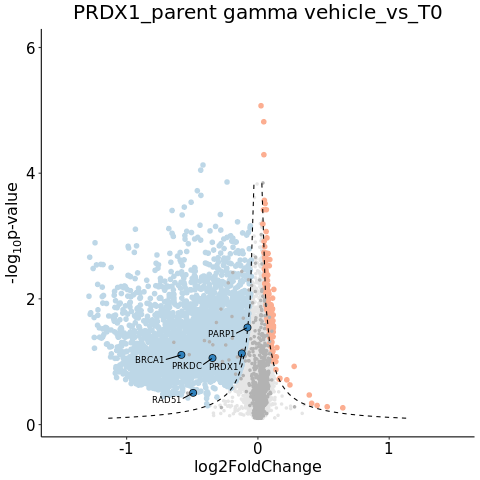

In [31]:
%%R -i df,screen_name,THRESHOLD

plot_volcano(df, xlim_l=-1.5,xlim_r=1.5, ylim=6,threshold=THRESHOLD) %>% 
    label_sensitivity_hit(df %>% filter(gene %in% c(
        "PRKDC",
        "PRDX1", 
        "RAD51", 
        "PARP1",
        "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

### tau

In [32]:
score = 'tau'
cond1 = "T0"
cond2 = "DNAPKi"

screen_name = f'PRDX1_parent {score} {cond2}_vs_{cond1}'

In [33]:
runPhenoScore(
    adata_parent,cond1,cond2,
    growth_rate_a=screengrowthsummary[screengrowthsummary.Day.eq(11)]['parent_DNAPKi'].values[0]
)

#### Save to results

In [34]:
results[screen_name] = ann_score_df(
    adata_parent.var[['target',f'condition_{cond2}_vs_{cond1}_delta',f'condition_{cond2}_vs_{cond1}_pvalue']], threshold=THRESHOLD
).loc[target_df.index,:].set_index('gene')

results[screen_name].groupby('label').size()

label
sensitivity_hit     3521
resistance_hit       149
gene_non_hit       16401
non-targeting       1026
dtype: int64

#### volcano plots

In [35]:
df = results[screen_name].reset_index().copy()

In [36]:
df.score.min(),df.score.max(), -np.log10(df.pvalue.min())

(-1.3534195678328478, 0.7799611437638805, 5.04683930598998)

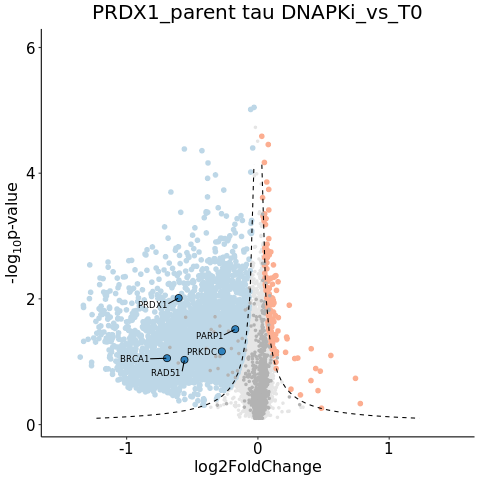

In [37]:
%%R -i df,screen_name,THRESHOLD

plot_volcano(df, xlim_l=-1.5,xlim_r=1.5, ylim=6,threshold=THRESHOLD) %>% 
    label_sensitivity_hit(df %>% filter(gene %in% c(
        "PRKDC",
        "PRDX1", 
        "RAD51", 
        "PARP1",
        "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

### rho

In [38]:
score = 'rho'
cond1 = "vehicle"
cond2 = "DNAPKi"

screen_name = f'PRDX1_parent {score} {cond2}_vs_{cond1}'

In [39]:
screengrowthsummary[screengrowthsummary.Day.eq(11)]['parent_vehicle'].values[0], screengrowthsummary[screengrowthsummary.Day.eq(11)]['parent_DNAPKi'].values[0]

(7.886372682035862, 7.570238506915568)

In [40]:
        screengrowthsummary[screengrowthsummary.Day.eq(11)]['parent_vehicle'].values[0],


(7.886372682035862,)

In [41]:
np.mean([
        screengrowthsummary[screengrowthsummary.Day.eq(11)]['parent_vehicle'].values[0],
        screengrowthsummary[screengrowthsummary.Day.eq(11)]['parent_DNAPKi'].values[0]
        ])

7.7283055944757155

In [42]:
runPhenoScore(
    adata_parent,cond1,cond2,n_reps=3,
    growth_rate_a=np.mean([
        screengrowthsummary[screengrowthsummary.Day.eq(11)]['parent_vehicle'].values[0],
        screengrowthsummary[screengrowthsummary.Day.eq(11)]['parent_DNAPKi'].values[0]
    ])
)

#### Save to results

In [43]:
results[screen_name] = ann_score_df(
    adata_parent.var[['target',f'condition_{cond2}_vs_{cond1}_delta',f'condition_{cond2}_vs_{cond1}_pvalue']], threshold=THRESHOLD
).loc[target_df.index,:].set_index('gene')

results[screen_name].groupby('label').size()

label
sensitivity_hit      861
resistance_hit       972
gene_non_hit       18238
non-targeting       1026
dtype: int64

#### volcano plots

In [44]:
df = results[screen_name].reset_index().copy()

In [45]:
df.score.min(),df.score.max(), -np.log10(df.pvalue.min())

(-0.5318002263298329, 0.5597622465611821, 4.949873972322147)

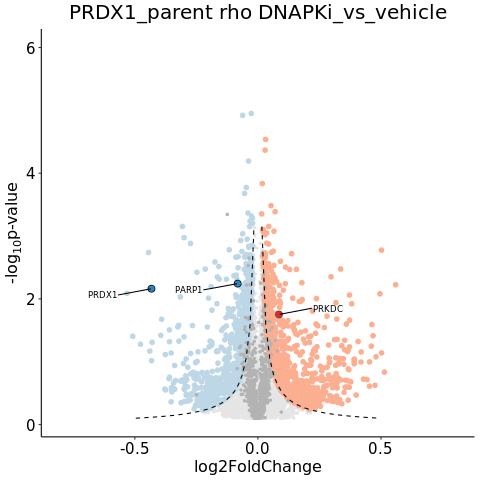

In [46]:
%%R -i df,screen_name,THRESHOLD

plot_volcano(df, xlim_l=-.8,xlim_r=.8, ylim=6,threshold=THRESHOLD) %>% 
    label_resistance_hit(df %>% filter(gene %in% c(
        "PRKDC"
    ))) -> p

p %>% label_sensitivity_hit(df %>% filter(gene %in% c(
        "PRDX1", 
        # "RAD51", 
        "PARP1"
        # "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

## PRDX1_KO

In [47]:
adata_KO = adata[adata.obs['cell line'].eq('PRDX1KO')].copy()

In [48]:
adata_KO.obs

,cell line,condition,rep,size_factors
i09,PRDX1KO,T0,1,0.747218
i10,PRDX1KO,T0,2,0.693424
i11,PRDX1KO,vehicle,1,1.091873
i12,PRDX1KO,vehicle,2,1.110228
i13,PRDX1KO,vehicle,3,2.439991
i14,PRDX1KO,DNAPKi,1,0.839602
i15,PRDX1KO,DNAPKi,2,0.867073
i16,PRDX1KO,DNAPKi,3,0.993045


### gamma

In [49]:
score = 'gamma'
cond1 = "T0"
cond2 = "vehicle"

screen_name = f'PRDX1_KO {score} {cond2}_vs_{cond1}'

In [50]:
runPhenoScore(
    adata_KO,cond1,cond2,
    growth_rate_a=screengrowthsummary[screengrowthsummary.Day.eq(11)]['PRDX1ko_vehicle'].values[0]
)

#### Save to results

In [51]:
results[screen_name] = ann_score_df(
    adata_KO.var[['target',f'condition_{cond2}_vs_{cond1}_delta',f'condition_{cond2}_vs_{cond1}_pvalue']], threshold=THRESHOLD
).loc[target_df.index,:].set_index('gene')

results[screen_name].groupby('label').size()

label
sensitivity_hit     3090
resistance_hit       228
gene_non_hit       16753
non-targeting       1026
dtype: int64

#### volcano plots

In [52]:
df = results[screen_name].reset_index().copy()

In [53]:
df.score.min(),df.score.max(), -np.log10(df.pvalue.min())

(-1.5873909737071163, 0.6758567375658425, 4.773006442112471)

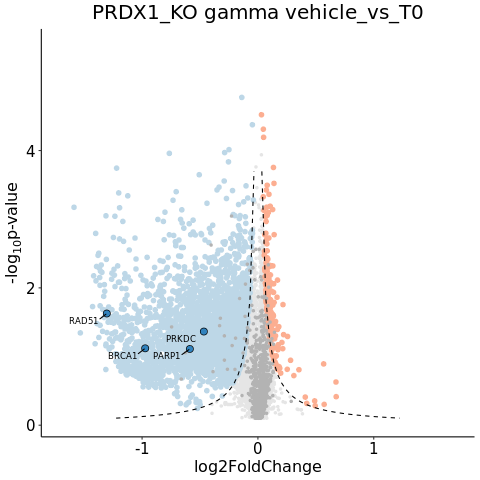

In [54]:
%%R -i df,screen_name,THRESHOLD

plot_volcano(df, xlim_l=-1.7,xlim_r=1.7, ylim=5.5,threshold=THRESHOLD) %>% 
    label_sensitivity_hit(df %>% filter(gene %in% c(
        "PRKDC",
        "PRDX1", 
        "RAD51", 
        "PARP1",
        "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

### tau

In [55]:
score = 'tau'
cond1 = "T0"
cond2 = "DNAPKi"

screen_name = f'PRDX1_KO {score} {cond2}_vs_{cond1}'

In [56]:
runPhenoScore(
    adata_KO,cond1,cond2,
    growth_rate_a=screengrowthsummary[screengrowthsummary.Day.eq(11)]['PRDX1ko_DNAPKi'].values[0]
)

#### Save to results

In [57]:
results[screen_name] = ann_score_df(
    adata_KO.var[['target',f'condition_{cond2}_vs_{cond1}_delta',f'condition_{cond2}_vs_{cond1}_pvalue']], threshold=THRESHOLD
).loc[target_df.index,:].set_index('gene')

results[screen_name].groupby('label').size()

label
sensitivity_hit     2600
resistance_hit       311
gene_non_hit       17160
non-targeting       1026
dtype: int64

#### volcano plots

In [58]:
df = results[screen_name].reset_index().copy()

In [59]:
df.score.min(),df.score.max(), -np.log10(df.pvalue.min())

(-4.320761347245577, 2.50273393574476, 5.1429128657912715)

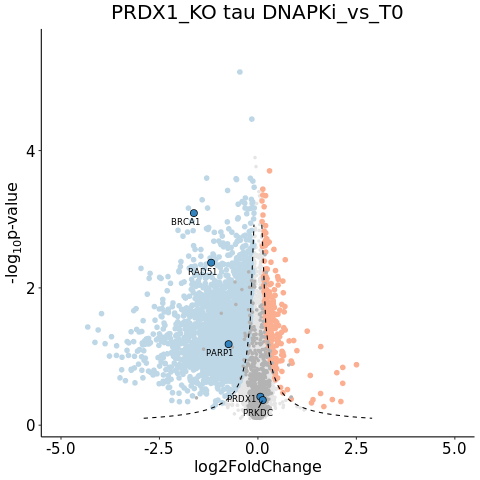

In [60]:
%%R -i df,screen_name,THRESHOLD

plot_volcano(df, xlim_l=-5,xlim_r=5, ylim=5.5,threshold=THRESHOLD) %>% 
    label_sensitivity_hit(df %>% filter(gene %in% c(
        "PRKDC",
        "PRDX1", 
        "RAD51", 
        "PARP1",
        "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

### rho

In [61]:
score = 'rho'
cond1 = "vehicle"
cond2 = "DNAPKi"

screen_name = f'PRDX1_KO {score} {cond2}_vs_{cond1}'

In [62]:
runPhenoScore(
    adata_KO,cond1,cond2,n_reps=3,
    growth_rate_a=np.mean([
        screengrowthsummary[screengrowthsummary.Day.eq(11)]['PRDX1ko_DNAPKi'].values[0],
        screengrowthsummary[screengrowthsummary.Day.eq(11)]['PRDX1ko_vehicle'].values[0]
    ])   
)

#### Save to results

In [63]:
results[screen_name] = ann_score_df(
    adata_KO.var[['target',f'condition_{cond2}_vs_{cond1}_delta',f'condition_{cond2}_vs_{cond1}_pvalue']], threshold=THRESHOLD
).loc[target_df.index,:].set_index('gene')

results[screen_name].groupby('label').size()

label
sensitivity_hit      414
resistance_hit      2847
gene_non_hit       16810
non-targeting       1026
dtype: int64

#### volcano plots

In [64]:
df = results[screen_name].reset_index().copy()

In [65]:
df.score.min(),df.score.max(), -np.log10(df.pvalue.min())

(-0.6683306973007509, 1.4346377630276346, 5.271176829106077)

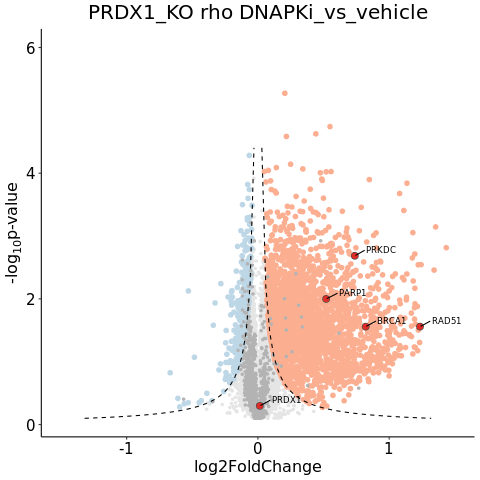

In [66]:
%%R -i df,screen_name,THRESHOLD

plot_volcano(df, xlim_l=-1.5,xlim_r=1.5, ylim=6,threshold=THRESHOLD) %>% 
    label_resistance_hit(df %>% filter(gene %in% c(
        "PRKDC",
        "PRDX1", 
        "RAD51", 
        "PARP1",
        "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

## vehicle
    vehicle_PRDX1KO_vs_vehicle_parent

In [67]:
adata_vehicle = adata[adata.obs['condition'].eq('vehicle')].copy()

adata_vehicle.obs['condition'] = adata_vehicle.obs['cell line']

del adata_vehicle.obs['cell line']

In [68]:
adata_vehicle.obs

,condition,rep,size_factors
i03,parent,1,1.313857
i04,parent,2,1.182584
i05,parent,3,1.273702
i11,PRDX1KO,1,1.091873
i12,PRDX1KO,2,1.110228
i13,PRDX1KO,3,2.439991


### rho

In [69]:
score = 'rho'
cond1 = "parent"
cond2 = "PRDX1KO"

screen_name = f'vehicle {score} {cond2}_vs_{cond1}'

In [70]:
runPhenoScore(
    adata_vehicle,cond1,cond2,n_reps=3,
    growth_rate_a=np.mean([
        screengrowthsummary[screengrowthsummary.Day.eq(11)]['parent_vehicle'].values[0],
        screengrowthsummary[screengrowthsummary.Day.eq(11)]['PRDX1ko_vehicle'].values[0]
    ])   

)

#### Save to results

In [71]:
results[screen_name] = ann_score_df(
    adata_vehicle.var[['target',f'condition_{cond2}_vs_{cond1}_delta',f'condition_{cond2}_vs_{cond1}_pvalue']], threshold=THRESHOLD
).loc[target_df.index,:].set_index('gene')

results[screen_name].groupby('label').size()

label
sensitivity_hit      894
resistance_hit      2643
gene_non_hit       16534
non-targeting       1026
dtype: int64

#### volcano plots

In [72]:
df = results[screen_name].reset_index().copy()

In [73]:
df.score.min(),df.score.max(), -np.log10(df.pvalue.min())

(-0.8137760570241723, 0.7871978884514287, 5.04728857360988)

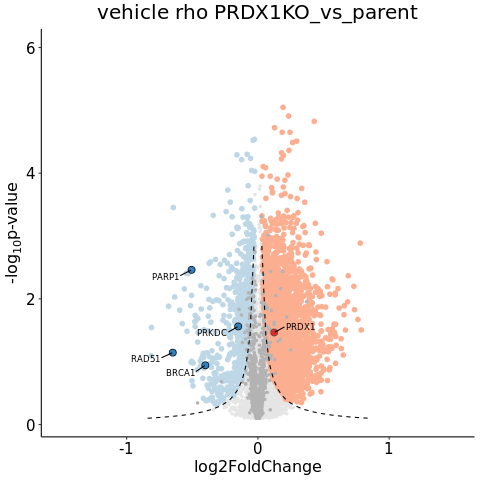

In [74]:
%%R -i df,screen_name,THRESHOLD

plot_volcano(df, xlim_l=-1.5,xlim_r=1.5, ylim=6,threshold=THRESHOLD) %>% 
    label_resistance_hit(df %>% filter(gene %in% c(
        "PRDX1"
    ))) -> p

p %>% label_sensitivity_hit(df %>% filter(gene %in% c(
        "PRKDC",
        "RAD51", 
        "PARP1",
        "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

## Save results as a excel

In [157]:
data = pd.concat(results,axis=1)

In [158]:
set(data.columns.to_frame()[0].to_list())

{'PRDX1_KO gamma vehicle_vs_T0',
 'PRDX1_KO rho DNAPKi_vs_vehicle',
 'PRDX1_KO tau DNAPKi_vs_T0',
 'PRDX1_parent gamma vehicle_vs_T0',
 'PRDX1_parent rho DNAPKi_vs_vehicle',
 'PRDX1_parent tau DNAPKi_vs_T0',
 'vehicle rho PRDX1KO_vs_parent'}

In [159]:
data.to_excel('phenotype_scores.xlsx')

# 

In [187]:
%load_ext watermark

In [188]:
%watermark

Last updated: 2023-05-26T16:08:32.130882-07:00

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.12.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 3.10.0-957.27.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit



In [189]:
%watermark --iversions

anndata   : 0.8.0
matplotlib: 3.7.1
pydeseq2  : 0.3.3
pandas    : 2.0.0
numpy     : 1.24.2

